## Импорты, загрузка файлов



In [102]:
import pandas as pd
import os
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import torch
import matplotlib.pyplot as plt

random_state = 1337


def set_seed(seed=random_state):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

In [103]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/simulations

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/simulations


In [104]:
file_name = "/content/drive/MyDrive/simulations/sim_res_1_without_false.csv"
df = pd.read_csv(file_name)

# Машинное обучение

## Изучение данных в датасете

In [105]:
df.head()

,dd,death_r,epochs_count,area_length_x,area_length_y,initial_pop,b,sd_b,sd_d,d,final_pop
0,0.21,1.95,3000,3,3,1,0.55,0.80,0.65,0.50,0
1,0.41,1.50,3000,3,3,1,0.75,0.80,0.50,0.30,6
2,0.01,1.50,3000,2,2,1,0.95,0.65,0.50,0.60,150
3,0.01,1.50,3000,2,2,1,0.95,0.65,0.50,0.20,266
4,0.16,2.85,3000,10,10,1,0.81,0.50,0.95,0.55,92


In [106]:
cor = df.drop(columns=['epochs_count', 'area_length_y', 'initial_pop']).corr()

<Axes: >

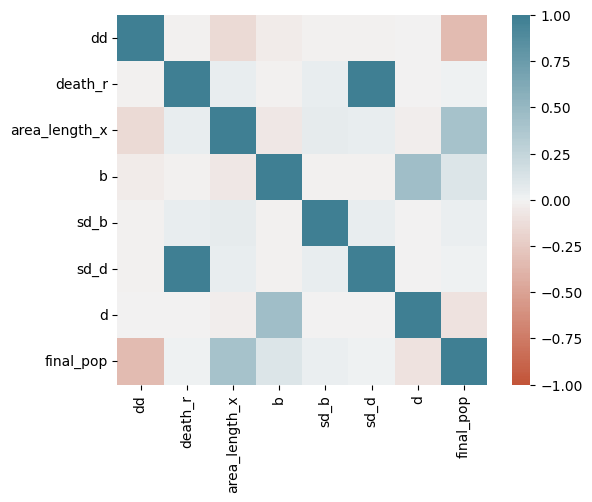

In [107]:
import seaborn as sns

sns.heatmap(
    cor, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14885 entries, 0 to 14884
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dd             14885 non-null  float64
 1   death_r        14885 non-null  float64
 2   epochs_count   14885 non-null  int64  
 3   area_length_x  14885 non-null  int64  
 4   area_length_y  14885 non-null  int64  
 5   initial_pop    14885 non-null  int64  
 6   b              14885 non-null  float64
 7   sd_b           14885 non-null  float64
 8   sd_d           14885 non-null  float64
 9   d              14885 non-null  float64
 10  final_pop      14885 non-null  int64  
dtypes: float64(6), int64(5)
memory usage: 1.2 MB


In [109]:
df["final_pop"].describe()

count    14885.000000
mean      1179.397044
std       3929.944025
min          0.000000
25%          0.000000
50%         24.000000
75%        447.000000
max      44592.000000
Name: final_pop, dtype: float64

In [110]:
df.drop(columns=['initial_pop', 'death_r', 'epochs_count', 'area_length_x']).describe()

,dd,area_length_y,b,sd_b,sd_d,d,final_pop
count,14885.000000,14885.000000,14885.000000,14885.000000,14885.000000,14885.000000,14885.000000
mean,0.184148,9.334296,0.604607,0.715220,0.715452,0.312241,1179.397044
std,0.136276,7.623667,0.203293,0.167367,0.167542,0.179478,3929.944025
min,0.010000,2.000000,0.150000,0.500000,0.500000,0.100000,0.000000
25%,0.110000,3.000000,0.450000,0.500000,0.500000,0.200000,0.000000
50%,0.210000,5.000000,0.650000,0.650000,0.650000,0.300000,24.000000
75%,0.310000,16.000000,0.760000,0.800000,0.800000,0.400000,447.000000
max,0.410000,25.000000,0.960000,0.950000,0.950000,0.700000,44592.000000


In [111]:
df["final_pop"].quantile([0.25, 0.5, 0.75, 0.9, 0.99])

0.25        0.00
0.50       24.00
0.75      447.00
0.90     2533.20
0.99    21923.44
Name: final_pop, dtype: float64

Нормализация данных

In [112]:
X = df.drop("final_pop", axis =1)
y = df["final_pop"]

scaler = StandardScaler()
X = scaler.fit_transform(X)

## Линейная регрессия

In [113]:
set_seed()
scores_linreg = cross_validate(LinearRegression(), X, y, cv=4,scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)

In [114]:
print("RMSE:",np.sqrt(-1*scores_linreg['test_neg_mean_squared_error']).mean())

RMSE: 3298.352321142484


## Случайный лес

In [115]:
set_seed()
scores_random_forest = cross_validate(RandomForestRegressor(max_depth=3, random_state=random_state), X, y, cv=4,scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)

In [116]:
set_seed()
best_rmse = 1000000000
best_params = [0, 0]
for depth in range(1,20,2):
  for leaves_num in [1,2,3,4, 5, 10, 15]:
    scores_random_forest = cross_validate(RandomForestRegressor(max_depth=depth,min_samples_leaf = leaves_num, random_state=random_state), X, y, cv=4,scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)
    cur_rmse = np.sqrt(-1*scores_random_forest['test_neg_mean_squared_error']).mean()
    if cur_rmse < best_rmse:
      best_rmse = cur_rmse
      best_params = [depth, leaves_num]

In [117]:
print(best_rmse)

307.98948969649217


In [118]:
print(best_params)

[15, 1]


## Градиентный бустинг

### Подбор оптимальных параметров

Для начала посмотрим, как результаты завсисят от каждого из параметров

In [ ]:
learning_rates = [1, 0.5, 0.4, 0.3, 0.25, 0.1, 0.05, 0.01]
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
max_depths = np.linspace(1, 32, 32, endpoint=True)
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leafs = np.linspace(0.1, 0.5, 10, endpoint=True)

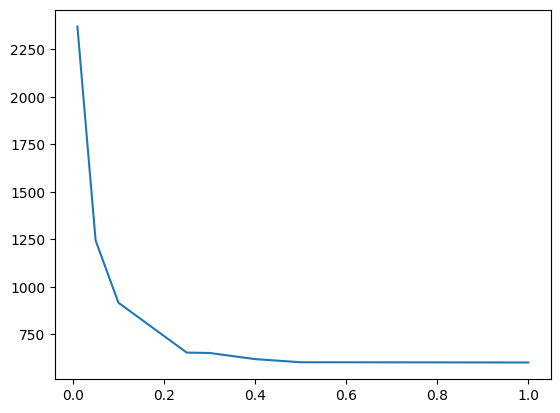

In [ ]:
set_seed()
best_rmse = 1000000000
rmse = []
best_params = [0, 0]
for lr in learning_rates:
  model_3 = GradientBoostingRegressor(random_state=random_state, learning_rate=lr)
  scores_gradient_boosting = cross_validate(model_3, X, y, cv=4,scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)
  cur_rmse = np.sqrt(-1*scores_gradient_boosting['test_neg_mean_squared_error']).mean()
  rmse.append(cur_rmse)
  if cur_rmse < best_rmse:
    best_rmse = cur_rmse
    
plt.plot(learning_rates, rmse)


708.9450237268252


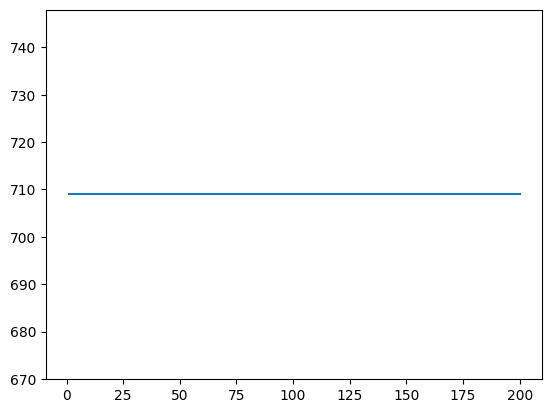

In [ ]:
set_seed()
best_rmse = 1000000000
rmse = []
best_params = [0, 0]
for n in n_estimators:
  model_3 = GradientBoostingRegressor(random_state=random_state, n_estimators=n_est)
  scores_gradient_boosting = cross_validate(model_3, X, y, cv=4,scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)
  cur_rmse = np.sqrt(-1*scores_gradient_boosting['test_neg_mean_squared_error']).mean()
  rmse.append(cur_rmse)
  if cur_rmse < best_rmse:
    best_rmse = cur_rmse

plt.plot(n_estimators, rmse)
print(best_rmse)


312.0066853892456


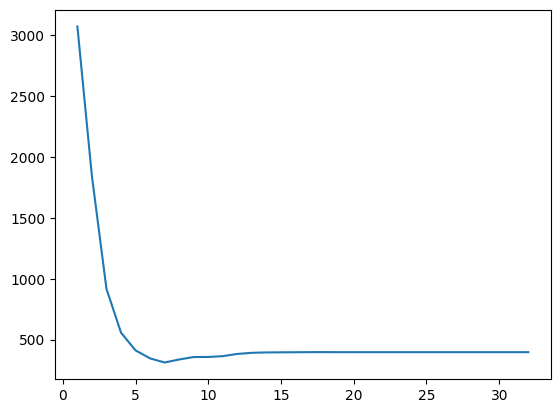

In [ ]:
set_seed()
best_rmse = 1000000000
rmse = []
best_params = [0, 0]
for m_d in max_depths:
  model_3 = GradientBoostingRegressor(random_state=random_state, max_depth=int(m_d))
  scores_gradient_boosting = cross_validate(model_3, X, y, cv=4,scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)
  cur_rmse = np.sqrt(-1*scores_gradient_boosting['test_neg_mean_squared_error']).mean()
  rmse.append(cur_rmse)
  if cur_rmse < best_rmse:
    best_rmse = cur_rmse

plt.plot(max_depths, rmse)
print(best_rmse)


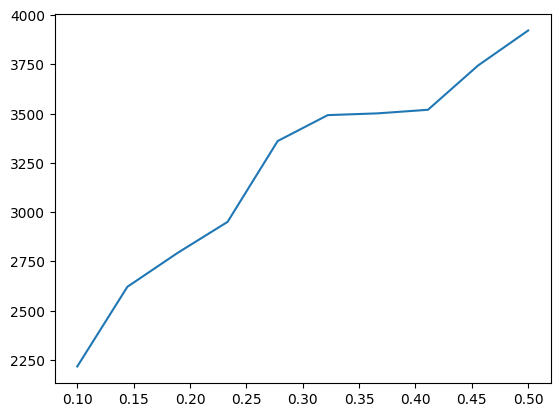

In [ ]:
set_seed()
best_rmse = 1000000000
rmse = []
best_params = [0, 0]
for l in min_samples_leafs:
  model_3 = GradientBoostingRegressor(random_state=random_state, min_samples_leaf=l)
  scores_gradient_boosting = cross_validate(model_3, X, y, cv=4,scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)
  cur_rmse = np.sqrt(-1*scores_gradient_boosting['test_neg_mean_squared_error']).mean()
  rmse.append(cur_rmse)
  if cur_rmse < best_rmse:
    best_rmse = cur_rmse

plt.plot(min_samples_leafs, rmse)

### Итоговый вариант

In [ ]:
learning_rates = [0.5, 0.4, 0.25, 0.1, 0.05, 0.01]
max_depths = np.linspace(5, 10, 5, endpoint=True)
min_samples_leafs = np.linspace(1,200, 5,  endpoint=True)

In [ ]:
set_seed()
best_rmse = 1000000000
best_params = [0, 0]
rmse = []
for lr in learning_rates:
    for m_d in max_depths:
      for l in min_samples_leafs:
        model_3 = GradientBoostingRegressor(random_state=random_state, learning_rate=lr, min_samples_leaf=int(l), max_depth=int(m_d))
        scores_gradient_boosting = cross_validate(model_3, X, y, cv=4,scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)
        cur_rmse = np.sqrt(-1*scores_gradient_boosting['test_neg_mean_squared_error']).mean()
        rmse.append(cur_rmse)
        if cur_rmse < best_rmse:
          best_rmse = cur_rmse
          best_params = [lr, m_d, l]



In [ ]:
best_rmse

312.0066853892456

In [ ]:
best_params

[0.1, 7.5, 1.0]

## Обучение нейронной сети

In [ ]:
from torch import nn

class MLP(nn.Module):
    def __init__(self, in_features, num_classes, hidden_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=num_classes, bias=False)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    '''
    Plot losses and metrics while training
      - train_losses: sequence of train losses
      - train_metrics: sequence of train MSE values
      - val_losses: sequence of validation losses
      - val_metrics: sequence of validation MSE values
    '''
    clear_output()
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.plot(range(1, len(train_metrics) + 1), train_metrics, label='train')
    ax.plot(range(1, len(val_metrics) + 1), val_metrics, label='val')

    #if max(train_losses) / min(train_losses) > 10:
    #    axs[0].set_yscale('log')
    #
    #if max(train_metrics) / min(train_metrics) > 10:
    #    axs[0].set_yscale('log')


    ax.set_xlabel('epoch')
    ax.legend()

    ax.set_ylabel('MSE')
    
    plt.show()


import torch
from tqdm.auto import tqdm


def train_and_validate(device, model, optimizer, criterion, metric, train_loader, val_loader,
                       num_epochs, verbose=True):
    '''
    Train and validate neural network
      - model: neural network to train
      - optimizer: optimizer chained to a model
      - criterion: loss function class
      - metric: function to measure MSE taking neural networks predictions
                 and ground truth labels
      - train_loader: DataLoader with train set
      - val_loader: DataLoader with validation set
      - num_epochs: number of epochs to train
      - verbose: whether to plot metrics during training
      - device: device to use for training and inference, e.g. 'cpu', 'cuda'
    Returns:
      - train_mse: training MSE over the last epoch
      - val_mse: validation MSE after the last epoch
    '''


    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, running_metric = 0, 0
        pbar = tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}') \
            if verbose else train_loader

        for i, (X_batch, y_batch) in enumerate(pbar, 1):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()

            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                metric_value = metric(predictions.to(device), y_batch)
                if type(metric_value) == torch.Tensor:
                    metric_value = metric_value.item()
                running_loss += loss.item() * X_batch.shape[0]
                running_metric += metric_value * X_batch.shape[0]

            if verbose and i % 100 == 0:
                pbar.set_postfix({'loss': loss.item(), 'MSE': metric_value})

        train_losses += [running_loss / len(train_loader.dataset)]
        train_metrics += [running_metric / len(train_loader.dataset)]

        model.eval()
        running_loss, running_metric = 0, 0
        pbar = tqdm(val_loader, desc=f'Validating {epoch}/{num_epochs}') \
            if verbose else val_loader

        for i, (X_batch, y_batch) in enumerate(pbar, 1):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)


            with torch.no_grad():
                predictions = model(torch.flatten(X_batch, start_dim = 1))
                loss = criterion(predictions, y_batch)

                metric_value = metric(predictions.to(device), y_batch)
                if type(metric_value) == torch.Tensor:
                    metric_value = metric_value.item()
                running_loss += loss.item() * X_batch.shape[0]
                running_metric += metric_value * X_batch.shape[0]

            if verbose and i % 100 == 0:
                pbar.set_postfix({'loss': loss.item(), 'MSE': metric_value})

        val_losses += [running_loss / len(val_loader.dataset)]
        val_metrics += [running_metric / len(val_loader.dataset)]

        if verbose:
            plot_losses(train_losses, train_metrics, val_losses, val_metrics)
    
    if verbose:
        print(f'Validation MSE: {val_metrics[-1]:.3f}')

    return train_metrics[-1], val_metrics[-1]


In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
from IPython.display import clear_output


set_seed()


#scaler = StandardScaler()
#X = scaler.fit_transform(X)



# X = df[df.final_pop < df.final_pop.quantile(.95)].drop("final_pop", axis =1)
# y = df[df.final_pop < df.final_pop.quantile(.95)]["final_pop"]


X = df.drop("final_pop", axis =1)
y = df["final_pop"]


#scaler = StandardScaler()
#X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

#scalerX = StandardScaler().fit(X_train)
#scalery = StandardScaler().fit(y_train)

#X_train = scalerX.transform(X_train)
#y_train = scalery.transform(y_train)
#X_test = scalerX.transform(X_test)
#y_test = scalery.transform(y_test)


X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)


NUM_EPOCHS = 10
num_classes = np.unique(y).shape[0]

train_loader = DataLoader(list(zip(X_train, y_train/y_train.max()*(num_classes-1) )), batch_size=16, shuffle=True)
val_loader = DataLoader(list(zip(X_test, y_test/y_test.max()*(num_classes-1))), batch_size=16, shuffle=True)

IN_SIZE = train_loader.dataset[0][0].shape[0]


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


my_model = MLP(in_features = IN_SIZE, num_classes = num_classes, hidden_size = 128).to(device)

optimizer = torch.optim.Adam(my_model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(my_model.parameters(), lr=0.01, momentum=0.9)
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
metric = nn.MSELoss()


#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

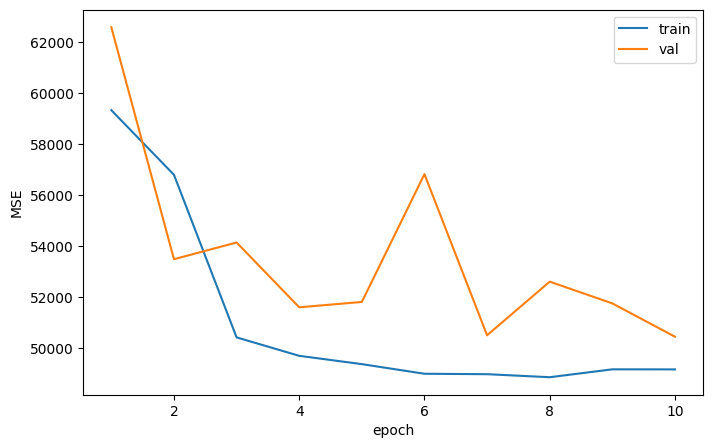

Validation MSE: 50453.632


(49171.419200866614, 50453.631599621556)

In [ ]:
train_and_validate(device, my_model, optimizer, criterion, metric, train_loader, val_loader, num_epochs=10)

In [ ]:
49171.419200866614 ** 0.5

221.74629467223713